In [1]:
# import statements
import import_ipynb
import pandas as pd

In [2]:
def LoadAndFormatData(date_to_begin=None):

    # Load data into pandas dataframe
    df = pd.read_parquet('Data/BoQ_Data.parquet')
    df['DATE'] = pd.to_datetime(df['DATE'])
    if date_to_begin is not None:
        date_to_begin = pd.to_datetime(date_to_begin)
        df = df[df['DATE'] >= date_to_begin]

    def AddMarketReturn(dataframe):
        """Adds a market return variable (mkt) to the dataframe"""

        # Define a function to calculate the weighted mean return
        def weighted_mean(group):
            return (group['RET'] * group['ME']).sum() / group['ME'].sum()

        # Group by 'year' and apply the weighted mean to each group
        dataframe['mkt'] = dataframe.groupby('DATE').apply(
            lambda group: pd.Series(weighted_mean(group), index=group.index)
        ).reset_index(drop=True)

        return dataframe
    
    df['RET_t+1'] = df.groupby("PERMNO")['RET'].shift(-1)
    df['PRC_t+1'] = df.groupby("PERMNO")['PRC'].shift(-1)
    
    df = AddMarketReturn(df)
    return df

In [3]:
def Bin_Portfolio(dataframe, vars_to_bin=['mkt'], go_long=[True], number_of_bins=5):
    """Parameters: 
        - vars_to_bin (list<string>): A list of variables around which binning should take place
        - coeff_signs (list[1 or -1]): A list indicating whether to go high or low in each bin
        - df (pd.Dataframe): a dataframe containing all of the necessary data.
        Returns:
        - portfolio: a dataframe containing stocks to go long in.
        - average return: the return of the portfolio (assuming equal weights)
    """

    if len(go_long) != len(vars_to_bin):
        raise ValueError(f"The length of go_long needs to be the same as the length of vars_to_bin. {len(go_long)} != {len(vars_to_bin)}")

    # Find the subset of the dataframe that we care about
    df = dataframe[['PERMNO', 'DATE', "PRC_t+1"] + vars_to_bin]
    df = df.dropna()
    df = df.reset_index(drop=True)

    bin_names = []
    best_bins = []
    for i, bin_var in enumerate(vars_to_bin):
        column_name = f"{bin_var}_bins"
        bin_names.append(column_name)

        if len(df.index) <= 1:
            raise ValueError("There are not enough stocks that satisfy the given requirements")
        df[column_name] = pd.qcut(df[bin_var],number_of_bins,labels=False)

        # Based on go_long, take the highest or lowest bin

        best_bin = number_of_bins - 1 if go_long[i] else 0

        df = df[df[column_name] == best_bin]

        # Delete the bin column name
        del df[column_name]

        best_bins.append(best_bin)

    # NOTE: This port stuff can be useful to visualize if there's only to variables to bin
    #port = df.groupby(bin_names)['RET'].mean()*100
    #port = port.unstack(level=bin_names[-1])
    df = df.reset_index(drop=True)

    return df

In [ ]:
df = LoadAndFormatData()

In [78]:
#This adds a price for the next time so I can use it
# df['PRC_t+1'] = df.groupby("PERMNO")['PRC'].shift(-1)

In [79]:
subset = df[df['DATE'] == '2021-01-31']

In [80]:
vars_list = ["mkt", "roic", "BEME", 'ME']
go_long = [True]*len(vars_list)
portfolio = Bin_Portfolio(dataframe=subset, vars_to_bin=vars_list, go_long=go_long)
portfolio

,PERMNO,DATE,PRC_t+1,mkt,roic,BEME,ME
0,11990.0,2021-01-31,45.560001,0.062958,0.141838,0.651590,2.216991e+07
1,16736.0,2021-01-31,17.250000,0.057852,0.085396,0.710474,9.768006e+06
2,75241.0,2021-01-31,148.570007,0.083886,0.112229,0.538726,2.617691e+07
3,87006.0,2021-01-31,167.179993,0.057735,0.102310,0.719306,7.291137e+06
4,91531.0,2021-01-31,81.019997,0.080689,0.084081,0.692103,8.398881e+06


In [81]:
#The PnL curve represents 
def generate_PnL(portfolio,subset,invest):
    pnl = 0
    #Gets the PERMNOs of the bin in a list
    PERMNO = portfolio["PERMNO"].to_list()

    for item in PERMNO:
        if pd.isna(subset.loc[subset['PERMNO'] == item, 'PRC_t+1'].values) or pd.isna(subset.loc[subset['PERMNO'] == item, 'PRC'].values):
            PERMNO.remove(item)

    perstock = invest/len(PERMNO)
    
    for item in PERMNO:
        #Gets the buy and next month sell price of a stock
        buyPrc = subset.loc[subset['PERMNO'] == item, 'PRC'].values
        sellPrc = subset.loc[subset['PERMNO'] == item, 'PRC_t+1'].values

        #Generates the percent return based on a constant, could remove easily
        pnl += perstock*(sellPrc/buyPrc)

    if pd.isna(pnl):
        print("RACA YOU FOOL")
        for item in PERMNO:
            buyPrc = subset.loc[subset['PERMNO'] == item, 'PRC'].values
            sellPrc = subset.loc[subset['PERMNO'] == item, 'PRC_t+1'].values
            print(buyPrc, sellPrc)
        print('\n')
    return pnl

In [82]:
print(generate_PnL(portfolio, subset, 100))

[106.53899461]


In [83]:
difDates = df["DATE"].tolist()
difDates= list(set(difDates))
difDates.sort()
allDates = difDates[20:-1]
from2010to2019 = difDates[660:768]
from2022 = difDates[804:]
from2010 = difDates[660:]

In [84]:
dates = from2010

In [85]:
print(difDates[804])

2022-01-31 00:00:00


In [86]:
t_array = []
pnlCum = []
pnl = []
sum = 0
Start_Money = 100
for date in dates:
    subset = df[df['DATE'] == date]
    portfolio = Bin_Portfolio(dataframe=subset, vars_to_bin=vars_list, go_long=go_long)
    t_array.append(date)
    val = generate_PnL(portfolio,subset,Start_Money)[0]
    
    if not pd.isna(val):
        Start_Money = val
    pnl.append(val-100)

ValueError: There are not enough stocks that satisfy the given requirements

In [70]:
print(t_array)
print(pnl)

[Timestamp('2010-01-31 00:00:00'), Timestamp('2010-02-28 00:00:00'), Timestamp('2010-03-31 00:00:00'), Timestamp('2010-04-30 00:00:00'), Timestamp('2010-05-31 00:00:00'), Timestamp('2010-06-30 00:00:00'), Timestamp('2010-07-31 00:00:00'), Timestamp('2010-08-31 00:00:00'), Timestamp('2010-09-30 00:00:00'), Timestamp('2010-10-31 00:00:00'), Timestamp('2010-11-30 00:00:00'), Timestamp('2010-12-31 00:00:00'), Timestamp('2011-01-31 00:00:00'), Timestamp('2011-02-28 00:00:00'), Timestamp('2011-03-31 00:00:00'), Timestamp('2011-04-30 00:00:00'), Timestamp('2011-05-31 00:00:00'), Timestamp('2011-06-30 00:00:00'), Timestamp('2011-07-31 00:00:00'), Timestamp('2011-08-31 00:00:00'), Timestamp('2011-09-30 00:00:00'), Timestamp('2011-10-31 00:00:00'), Timestamp('2011-11-30 00:00:00'), Timestamp('2011-12-31 00:00:00'), Timestamp('2012-01-31 00:00:00'), Timestamp('2012-02-29 00:00:00'), Timestamp('2012-03-31 00:00:00'), Timestamp('2012-04-30 00:00:00'), Timestamp('2012-05-31 00:00:00'), Timestamp('20

In [71]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Profit')

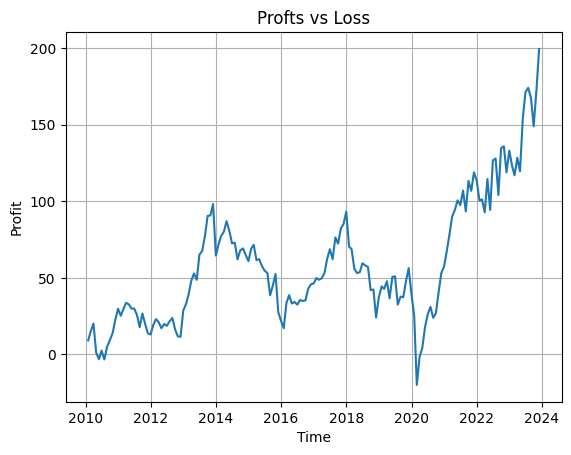

In [72]:
plt.plot(t_array,pnl)
plt.grid()
plt.title("Profts vs Loss")
plt.xlabel("Time")
plt.ylabel("Profit")

In [73]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Sample trade data
# # Assuming you have a list of trades with entry and exit prices and quantities
# trades = [
#     {'entry_price': 100, 'exit_price': 110, 'quantity': 10},
#     {'entry_price': 110, 'exit_price': 105, 'quantity': 5},
#     {'entry_price': 105, 'exit_price': 120, 'quantity': 15},
# ]

# # Create a DataFrame to store trades
# trade_df = pd.DataFrame(trades)

# # Calculate PnL for each trade
# trade_df['pnl'] = (trade_df['exit_price'] - trade_df['entry_price']) * trade_df['quantity']

# # Cumulative PnL over time
# trade_df['cumulative_pnl'] = trade_df['pnl'].cumsum()

# # Generate a time index for plotting (assuming trades happen sequentially)
# trade_df['time'] = range(len(trade_df))

# # Plotting the PnL curve
# plt.figure(figsize=(10, 6))
# plt.plot(trade_df['time'], trade_df['cumulative_pnl'], marker='o', linestyle='-')
# plt.title('Profit and Loss (PnL) Curve')
# plt.xlabel('Trade Number')
# plt.ylabel('Cumulative PnL')
# plt.grid()
# plt.show()
